# Get Started

## Preliminary work

1. Load the eventstudy module and its dependencies: numpy and matplotlib:

In [1]:
import eventstudies as es
print(es.__version__)
from eventstudies import SingleEvent, MultipleEvents

import numpy as np
import matplotlib.pyplot as plt

0.1.0.dev1


2. Set the parameters needed for your events: the returns and Fama-French factors (using `SingleEvent.import_returns()` and `SingleEvent.import_FamaFrench()`):

In [4]:
# Import returns from CSV file
import pandas as pd
returns_df = pd.read_csv('../data/returns_GAFAM.csv')
returns_df['date'] = pd.to_datetime(returns_df['date'])
SingleEvent.import_returns(dataframe=returns_df)

# Import Fama-French factors (fetches from pandas_datareader)
# If you have a local CSV file, you can load it and pass it similarly
SingleEvent.import_FamaFrench()

## Example 1: A single event

As an introductory example, we will compute the event study analysis of the announcement of the first iphone, made by Steve Jobs during MacWorld exhibition, on January 7, 2007.

1. Run the event study, here using the Market Model:

In [5]:
source = [{
    "ticker": "AAPL",
    "mkt_idx": 'SPY',
    "event_date": '2007-01-09',
},
{
    "ticker": "MSFT",
    "mkt_idx": 'SPY',
    "event_date": '2007-01-09'
},
{
    "ticker": "AAPL",
    "mkt_idx": 'SPY',
    "event_date": '2008-01-09'
}]


results = []
results_full = []


for item in source:
    event = SingleEvent.MarketModel(
        ticker = item['ticker'],
        mkt_idx = item['mkt_idx'],
        event_date = np.datetime64(item['event_date']),
        event_window = (-2,10), 
        est_size = 300,
        buffer_size = 30
    )
    
    results.append(event.results(asterisks=False).tail(1))
    results_full.append(event)
    

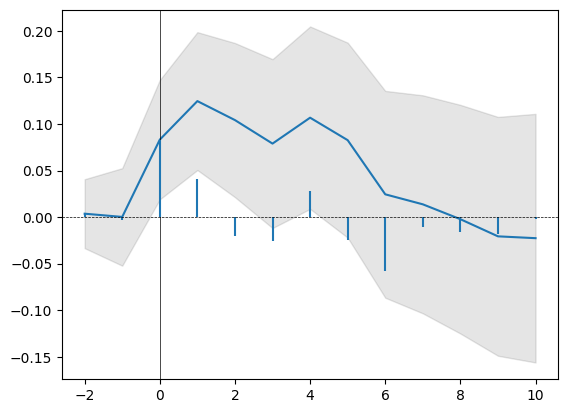

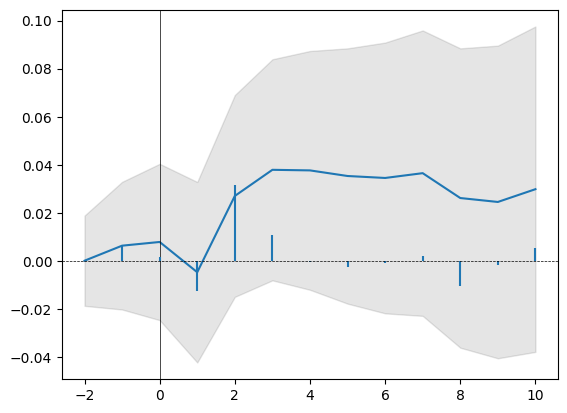

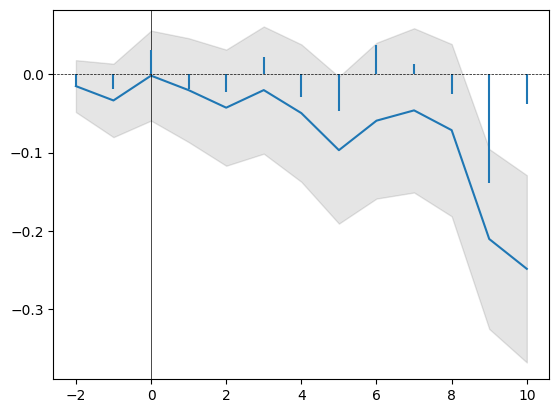

In [6]:
for event in results_full:
    event.plot(AR=True)

2. Display results:
    - In a plot:
        - grey area: confidence interval (here at 90%)
        - blue line: CAR
        - black bars: AR (displayed because AR parameter is set as True)

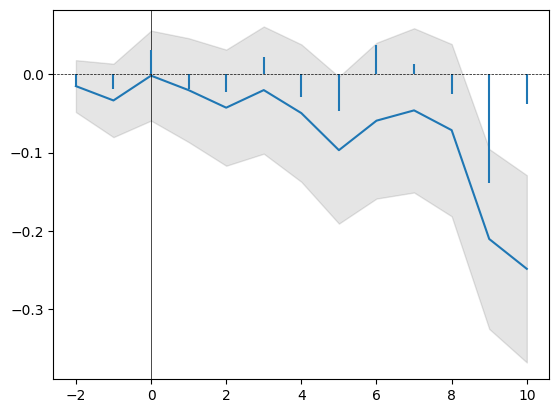

In [7]:
event.plot(AR=True)
plt.show()

Or in a table:

3. Export results to Excel:


In [8]:
event.results(decimals=[3,5,3,5,2,2])

,AR,StdErr AR,CAR,StdErr CAR,T-stat,P-value,Signif
-2,-0.015,0.02014,-0.015,0.02014,-0.74,0.46,
-1,-0.018,0.02014,-0.033,0.02849,-1.17,0.24,
0,0.032,0.02014,-0.002,0.03489,-0.04,0.97,
1,-0.019,0.02014,-0.020,0.04029,-0.50,0.62,
2,-0.022,0.02014,-0.043,0.04505,-0.94,0.35,
3,0.022,0.02014,-0.020,0.04934,-0.41,0.69,
4,-0.029,0.02014,-0.049,0.05330,-0.93,0.35,
5,-0.047,0.02014,-0.097,0.05698,-1.70,0.09,*
6,0.038,0.02014,-0.059,0.06043,-0.98,0.33,
7,0.013,0.02014,-0.046,0.06370,-0.72,0.47,


In [12]:
# Export to Excel - two options:

# Option 1: Simple export using pandas (just the results table)
# Use the first event from results_full (created in previous cell)
event = results_full[0]
event.results().to_excel('../outputs/export.xlsx')

# Option 2: Full-featured export with charts and formatting (requires excel_exporter)
# First import the excel_exporter module to enable the to_excel() method
from eventstudies import excel_exporter
# Then use the enhanced to_excel() method with charts and formatting
event.to_excel('../outputs/export_enhanced.xlsx', chart_as_picture=False)

## Example 2: An aggregate of events

The eventstudies package offers several different entry points. The list of events can be provided using a CSV file, a pandas DataFrame, an Excel file, or a Python list.

In this second example, based on the same data and preliminary work, we will compute an event study on GAFA annual report (10-K form) releases.

### Data preparation

The first step is to gather the data about the events and to format it. For the purpose of this example we will use a CSV file. The CSV file must contain all information needed to compute the model.

The event study will be computed using the Market Model. According to the API documentation, aside from event study parameters which will be set globally for all events (event_window, est_size and buffer_size), the Market Model needs the ticker, mkt_idx and event_date parameters.

Thus, the CSV file should contain three columns with the exact same names as the parameter names: `ticker`, `mkt_idx`, and `event_date`.

**Note:** The csv file must use comma (‘,’) as separator.

### Event study computation

To create an event study analysis of an aggregate of events, we will use the `MultipleEvents` class. This class is designed following the same spirit and structure of the `SingleEvent` class.

Run the event study. Since the CSV file uses DD/MM/YYYY date format, we'll read it manually, parse the dates, and use `from_pandas`. Alternatively, you can use `from_csv` with `sep=','` if your dates are in a standard format that pandas can auto-parse:

In [22]:
# Option 1: Use from_csv with comma separator (if dates are in standard format)
# Note: from_csv uses pipe separator by default, so we need to specify sep=','
# However, for DD/MM/YYYY dates, we need to parse manually first

# Option 2: Read CSV manually and parse dates, then use from_pandas (recommended for DD/MM/YYYY)
import pandas as pd
df = pd.read_csv('../data/10K.csv', sep=',')
# Parse dates in DD/MM/YYYY format
df['event_date'] = pd.to_datetime(df['event_date'], format='%d/%m/%Y')
# Convert to numpy datetime64 format
df['event_date'] = df['event_date'].apply(lambda x: np.datetime64(x))

# Use from_pandas to have control over date parsing
release_10K = MultipleEvents.from_pandas(
    df = df,
    event_model = SingleEvent.MarketModel,
    event_window = (-5,+10),
    est_size = 200,
    buffer_size = 30,
    ignore_errors = True
)

WARNING -  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling   MultipleEvents.error_report() method  or by exploring MultipleEvents.errors class variable.


**Note:** The event_study_model parameter must point to a function. This function can either be a model function provided by the Single class or a user-defined function.

When the ignore_errors parameter is set to True (which is its default value), the event study analysis will be computed regardless of any error encounter. Event triggering an error will be remove of the sample. Use error_report method to get the full list of error and their explanation. Errors are often coming from data unavailability.

Set the ignore_errors to False if you prefer the analysis to stop at the first error.

In [15]:
print(release_10K.error_report())

Error Report
3 errors due to data unavailability.
The respective events was not processed and thus removed from the sample.
It does not affect the computation of other events.
Help 1: Check if the company was quoted at this date, 
Help 2: For event study modelised used Fama-French models,
        check if the Fama-French dataset imported is up-to-date.
Tips:   Re-import all parameters and re-run the event study analysis.
Details
(You can find more details on errors in the documentation.)
Error            Date                Parameters              
---------------- ------------------- --------------------------
DateMissingError 2020-02-04 00:00:00 ticker: GOOG; mkt_idx: SPY
Description: Date (2020-02-04 00:00:00) is missing in returns.

DateMissingError 2020-01-31 00:00:00 ticker: AMZN; mkt_idx: SPY
Description: Date (2020-01-31 00:00:00) is missing in returns.

DateMissingError 2020-01-30 00:00:00 ticker: FB; mkt_idx: SPY  
Description: Date (2020-01-30 00:00:00) is missing in returns

### Display results:
In a plot:

*grey area: confidence interval (here defined by the user at 95%); blue line: CAAR*

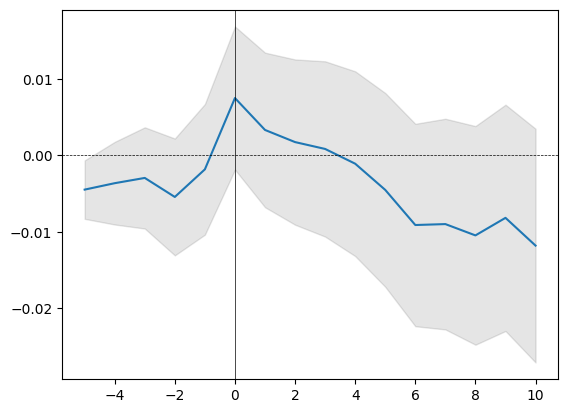

In [16]:
release_10K.plot(confidence=.95)
plt.show() # use standard matplotlib function to display the plot

Or in a table:

**Note:** Asterisks are added automatically to highlight the level of significance (Significance level: *** at 99%, ** at 95%, * at 90%). You can remove asterisks by setting asterisks parameter at False.

decimals is a list of integer setting for each column (except index) the rounding decimal. You can also set one integer (e.g. decimals = 3) if you want all columns to be rounded the same.

See the documentation on this results function for more details.

In [17]:
release_10K.results(decimals=[3,5,3,5,2,2])

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,-0.004,0.00233,-0.004,0.00233,-1.93,0.05,*
-4,0.001,0.00233,-0.004,0.00329,-1.11,0.27,
-3,0.001,0.00233,-0.003,0.00403,-0.73,0.46,
-2,-0.002,0.00233,-0.005,0.00465,-1.17,0.24,
-1,0.004,0.00233,-0.002,0.00520,-0.35,0.72,
0,0.009,0.00233,0.008,0.00570,1.32,0.19,
1,-0.004,0.00233,0.003,0.00615,0.54,0.59,
2,-0.002,0.00233,0.002,0.00658,0.26,0.79,
3,-0.001,0.00233,0.001,0.00698,0.12,0.90,
4,-0.002,0.00233,-0.001,0.00735,-0.15,0.88,


Get CAR distribution:

In [18]:
release_10K.get_CAR_dist(4)

,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,15,38,0.3947,-0.0045,0.0003,3.7574,-0.2714,-0.0466,-0.0109,-0.0048,0.0045,0.0372
-4,19,38,0.5000,-0.0036,0.0006,2.8801,-0.3267,-0.0600,-0.0147,0.0004,0.0069,0.0507
-3,17,38,0.4474,-0.0030,0.0009,3.1443,-0.1972,-0.0843,-0.0229,-0.0047,0.0173,0.0617
-2,14,38,0.3684,-0.0054,0.0007,2.9984,0.2398,-0.0637,-0.0212,-0.0074,0.0064,0.0553
-1,17,38,0.4474,-0.0018,0.0012,3.3359,0.4938,-0.0693,-0.0227,-0.0082,0.0139,0.0915
0,19,38,0.5000,0.0075,0.0036,4.5656,1.1312,-0.1044,-0.0285,-0.0014,0.0253,0.2007
1,16,38,0.4211,0.0033,0.0044,4.0385,1.0417,-0.1013,-0.0370,-0.0125,0.0236,0.2110
2,15,38,0.3947,0.0017,0.0049,3.2146,0.9171,-0.0948,-0.0419,-0.0153,0.0323,0.1875
3,15,38,0.3947,0.0008,0.0052,3.4870,0.9131,-0.1281,-0.0448,-0.0190,0.0296,0.1981
4,15,38,0.3947,-0.0011,0.0051,3.6812,0.9303,-0.1233,-0.0410,-0.0192,0.0256,0.2090


## Bonus: Loop in events

The true strength of this package is to use Python. You can create complex algorithms to compute programmatically event study analyses. From the same data as above, we will compute an event study of 10-K form releases for each company.

### Data preparation
This time, we will use the `from_list` method which sets the event list using a Python list. This lets the user manipulate the list of events before computing event studies. This list must contain all parameters needed to compute the selected model (here we will use the Fama-French 3-factor model). The Fama-French factors have to be set using the `SingleEvent.import_FamaFrench()` method (see preliminary step).

In [19]:
events_db = [
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2019-10-31')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2018-11-05')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2017-11-03')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2016-10-26')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2015-10-28')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2014-10-27')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2013-10-30')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2012-10-31')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2011-10-26')},
    {'ticker': 'AAPL', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2010-10-27')},
    {'ticker': 'GOOG', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2020-02-04')},
    {'ticker': 'GOOG', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2019-02-05')},
    {'ticker': 'GOOG', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2018-02-06')},
    {'ticker': 'GOOG', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2017-02-03')},
    {'ticker': 'GOOG', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2016-02-11')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2020-01-30')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2019-01-31')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2018-02-01')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2016-01-28')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2015-01-29')},
    {'ticker': 'FB', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2014-01-31')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2020-01-31')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2019-02-01')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2018-02-02')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2017-02-10')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2016-01-29')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2015-01-30')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2013-01-30')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2012-02-01')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2011-01-28')},
    {'ticker': 'AMZN', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2010-01-29')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2019-08-01')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2018-08-03')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2017-08-02')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2016-07-28')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2015-07-31')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2014-07-31')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2013-07-30')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2012-07-26')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2011-07-28')},
    {'ticker': 'MSFT', 'mkt_idx': 'SPY', 'event_date': np.datetime64('2010-07-30')}
]

### Event studies computation
Using a list comprehension, the full list of events can be filtered to create one list per company’s ticker. Then we can compute for each company the event study using the Fama-French 3 factor model and store each event study in a releases dictionary.

In [20]:
tickers = ['GOOG', 'AAPL', 'FB', 'AMZN', 'MSFT']
releases = dict()

for ticker in tickers:
    events = [event for event in events_db if event['ticker']==ticker]
    
    releases[ticker] = MultipleEvents.from_list(
        event_list=events,
        event_model=SingleEvent.FamaFrench3,
        event_window=(-5,+10)
    )

WARNING - 1 event has not been processed due to data issues.
Tips: Get more details on errors by calling   MultipleEvents.error_report() method  or by exploring MultipleEvents.errors class variable.
WARNING - 1 event has not been processed due to data issues.
Tips: Get more details on errors by calling   MultipleEvents.error_report() method  or by exploring MultipleEvents.errors class variable.
WARNING - 1 event has not been processed due to data issues.
Tips: Get more details on errors by calling   MultipleEvents.error_report() method  or by exploring MultipleEvents.errors class variable.


### Display results

GOOG


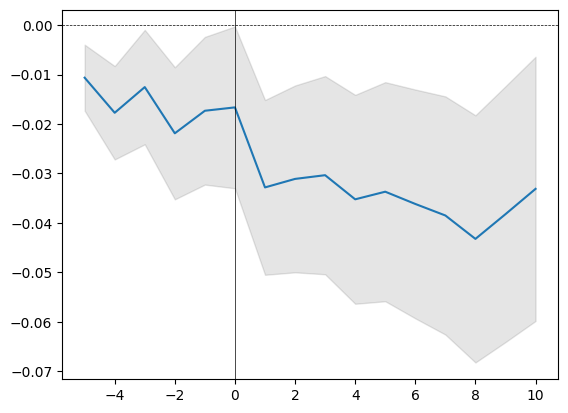

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,-0.0106,0.0052,-0.0106,0.0052,-2.0407,0.0415,**
-4,-0.0071,0.0052,-0.0177,0.0074,-2.4059,0.0163,**
-3,0.0052,0.0052,-0.0125,0.0090,-1.3887,0.1652,
-2,-0.0093,0.0052,-0.0219,0.0104,-2.0999,0.0360,**
-1,0.0046,0.0052,-0.0173,0.0116,-1.4866,0.1374,
0,0.0007,0.0052,-0.0166,0.0128,-1.3037,0.1926,
1,-0.0162,0.0052,-0.0328,0.0138,-2.3814,0.0174,**
2,0.0017,0.0052,-0.0311,0.0147,-2.1109,0.0350,**
3,0.0008,0.0052,-0.0304,0.0156,-1.9420,0.0524,*
4,-0.0049,0.0052,-0.0352,0.0165,-2.1387,0.0327,**


,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,1,4,0.25,-0.0106,0.0001,1.7264,-0.1877,-0.0270,-0.0175,-0.0098,-0.0029,0.0040
-4,1,4,0.25,-0.0177,0.0004,1.2138,0.1371,-0.0396,-0.0367,-0.0200,-0.0011,0.0088
-3,2,4,0.50,-0.0125,0.0005,1.7964,-0.5405,-0.0462,-0.0240,-0.0074,0.0041,0.0109
-2,0,4,0.00,-0.0219,0.0003,1.5723,-0.3729,-0.0484,-0.0334,-0.0185,-0.0069,-0.0022
-1,1,4,0.25,-0.0173,0.0004,1.5931,-0.3234,-0.0480,-0.0308,-0.0141,-0.0006,0.0069
0,1,4,0.25,-0.0166,0.0004,1.7177,-0.2394,-0.0457,-0.0286,-0.0147,-0.0027,0.0086
1,0,4,0.00,-0.0328,0.0002,1.4932,0.2178,-0.0475,-0.0428,-0.0342,-0.0242,-0.0154
2,0,4,0.00,-0.0311,0.0003,1.0475,0.0027,-0.0492,-0.0466,-0.0312,-0.0157,-0.0129
3,1,4,0.25,-0.0304,0.0005,1.7598,0.6002,-0.0501,-0.0488,-0.0372,-0.0188,0.0031
4,0,4,0.00,-0.0352,0.0004,1.3486,0.2187,-0.0582,-0.0540,-0.0382,-0.0195,-0.0063


AAPL


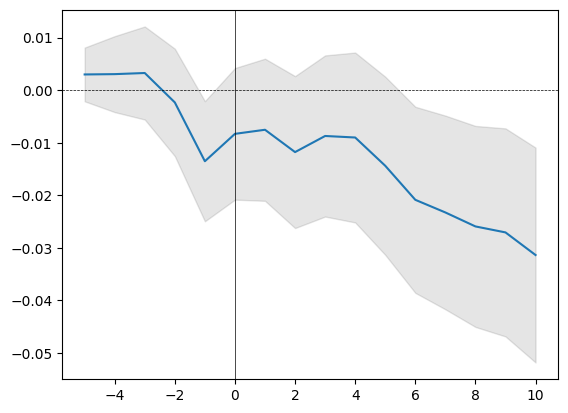

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,0.0030,0.004,0.0030,0.0040,0.7478,0.4547,
-4,0.0001,0.004,0.0030,0.0056,0.5395,0.5896,
-3,0.0002,0.004,0.0033,0.0069,0.4716,0.6372,
-2,-0.0056,0.004,-0.0023,0.0080,-0.2934,0.7692,
-1,-0.0112,0.004,-0.0135,0.0089,-1.5178,0.1292,
0,0.0052,0.004,-0.0083,0.0098,-0.8517,0.3945,
1,0.0008,0.004,-0.0075,0.0105,-0.7149,0.4747,
2,-0.0042,0.004,-0.0118,0.0113,-1.0456,0.2959,
3,0.0031,0.004,-0.0087,0.0120,-0.7294,0.4658,
4,-0.0003,0.004,-0.0090,0.0126,-0.7150,0.4747,


,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,5,10,0.5,0.0030,0.0004,3.5436,-0.4330,-0.0422,-0.0049,0.0013,0.0139,0.0402
-4,6,10,0.6,0.0030,0.0006,2.8689,-0.4462,-0.0502,-0.0091,0.0003,0.0196,0.0431
-3,6,10,0.6,0.0033,0.0012,3.2537,-0.7349,-0.0750,-0.0057,0.0054,0.0249,0.0557
-2,4,10,0.4,-0.0023,0.0009,2.2361,-0.0505,-0.0583,-0.0194,-0.0062,0.0173,0.0460
-1,3,10,0.3,-0.0135,0.0014,2.0560,0.3143,-0.0651,-0.0350,-0.0185,0.0049,0.0477
0,4,10,0.4,-0.0083,0.0018,2.3963,-0.2103,-0.0885,-0.0312,-0.0057,0.0165,0.0634
1,5,10,0.5,-0.0075,0.0024,1.9878,-0.0574,-0.0842,-0.0419,-0.0012,0.0181,0.0743
2,5,10,0.5,-0.0118,0.0028,1.6788,0.0610,-0.0840,-0.0597,-0.0061,0.0219,0.0716
3,5,10,0.5,-0.0087,0.0025,1.8184,0.0212,-0.0873,-0.0514,-0.0053,0.0247,0.0744
4,5,10,0.5,-0.0090,0.0028,1.7939,0.0063,-0.0949,-0.0488,-0.0052,0.0252,0.0783


FB


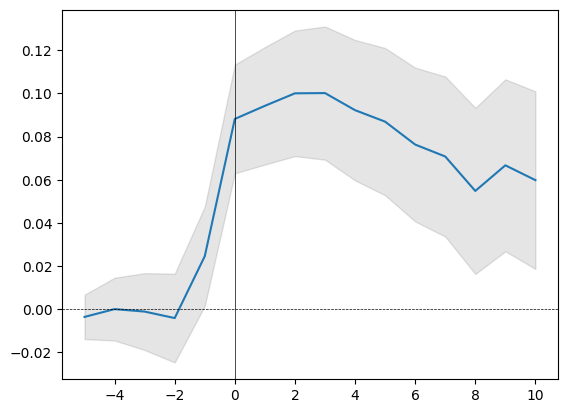

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,-0.0036,0.008,-0.0036,0.0080,-0.4462,0.6555,
-4,0.0036,0.008,0.0000,0.0113,0.0036,0.9971,
-3,-0.0011,0.008,-0.0011,0.0139,-0.0797,0.9365,
-2,-0.0030,0.008,-0.0041,0.0160,-0.2565,0.7976,
-1,0.0287,0.008,0.0245,0.0179,1.3677,0.1717,
0,0.0636,0.008,0.0882,0.0197,4.4857,0.0000,***
1,0.0061,0.008,0.0942,0.0212,4.4392,0.0000,***
2,0.0058,0.008,0.1000,0.0227,4.4080,0.0000,***
3,0.0001,0.008,0.1001,0.0241,4.1605,0.0000,***
4,-0.0079,0.008,0.0922,0.0254,3.6348,0.0003,***


,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,1,5,0.2,-0.0036,0.0001,2.2067,0.8451,-0.0107,-0.0091,-0.0072,-0.0005,0.0097
-4,2,5,0.4,0.0000,0.0001,1.9359,0.7500,-0.0101,-0.0097,-0.0071,0.0068,0.0203
-3,3,5,0.6,-0.0011,0.0004,1.3972,-0.0898,-0.0247,-0.0229,0.0055,0.0116,0.0250
-2,2,5,0.4,-0.0041,0.0001,2.6840,-1.0391,-0.0251,-0.0049,-0.0004,0.0024,0.0074
-1,2,5,0.4,0.0245,0.0023,2.8522,1.2501,-0.0102,-0.0069,-0.0038,0.0266,0.1169
0,4,5,0.8,0.0882,0.0039,1.3867,-0.3769,-0.0024,0.0305,0.1161,0.1421,0.1545
1,4,5,0.8,0.0942,0.0045,1.5720,-0.4021,-0.0081,0.0440,0.1135,0.1592,0.1626
2,4,5,0.8,0.1000,0.0059,1.7719,-0.5363,-0.0245,0.0519,0.1243,0.1728,0.1757
3,4,5,0.8,0.1001,0.0070,1.7573,-0.5112,-0.0352,0.0465,0.1263,0.1743,0.1888
4,4,5,0.8,0.0922,0.0064,1.5225,-0.4563,-0.0304,0.0277,0.1261,0.1687,0.1691


AMZN


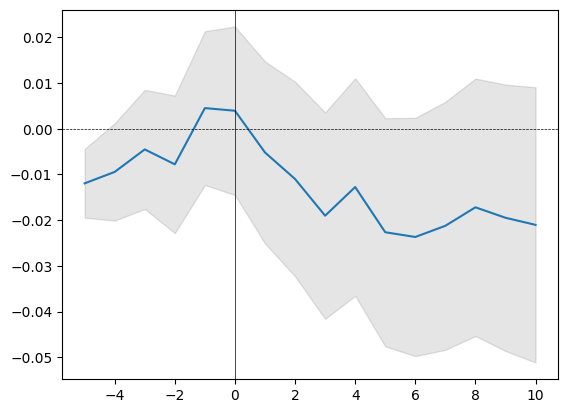

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,-0.0120,0.0059,-0.0120,0.0059,-2.0350,0.0420,**
-4,0.0025,0.0059,-0.0094,0.0083,-1.1372,0.2556,
-3,0.0049,0.0059,-0.0045,0.0102,-0.4444,0.6568,
-2,-0.0033,0.0059,-0.0078,0.0117,-0.6629,0.5075,
-1,0.0123,0.0059,0.0045,0.0131,0.3441,0.7308,
0,-0.0006,0.0059,0.0039,0.0144,0.2739,0.7842,
1,-0.0091,0.0059,-0.0052,0.0155,-0.3341,0.7383,
2,-0.0058,0.0059,-0.0110,0.0166,-0.6623,0.5079,
3,-0.0080,0.0059,-0.0190,0.0176,-1.0798,0.2803,
4,0.0063,0.0059,-0.0128,0.0186,-0.6868,0.4923,


,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,2,9,0.2222,-0.0120,0.0002,2.3351,0.0185,-0.0372,-0.0205,-0.0112,-0.0072,0.0111
-4,4,9,0.4444,-0.0094,0.0005,1.5098,-0.3671,-0.0427,-0.0346,-0.0079,0.0095,0.0166
-3,5,9,0.5556,-0.0045,0.0010,1.3061,0.0082,-0.0439,-0.0352,0.0000,0.0230,0.0383
-2,5,9,0.5556,-0.0078,0.0008,2.4032,0.0313,-0.0559,-0.0247,0.0037,0.0064,0.0458
-1,5,9,0.5556,0.0045,0.0016,3.3764,0.7457,-0.0497,-0.0170,0.0091,0.0183,0.0944
0,4,9,0.4444,0.0039,0.0054,3.6222,1.2367,-0.0680,-0.0528,-0.0066,0.0195,0.1766
1,2,9,0.2222,-0.0052,0.0077,3.6662,1.4525,-0.0796,-0.0506,-0.0392,-0.0226,0.1999
2,2,9,0.2222,-0.0110,0.0076,3.2473,1.3476,-0.0793,-0.0664,-0.0392,-0.0291,0.1837
3,2,9,0.2222,-0.0190,0.0086,3.3970,1.3554,-0.1076,-0.0697,-0.0563,-0.0412,0.1916
4,2,9,0.2222,-0.0128,0.0094,3.2055,1.3122,-0.1003,-0.0723,-0.0538,-0.0279,0.2023


MSFT


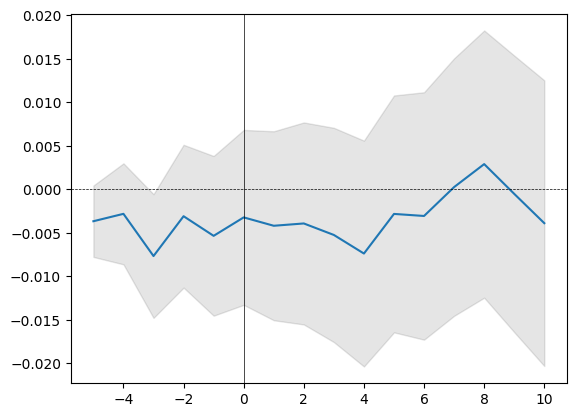

,AAR,StdErr AAR,CAAR,StdErr CAAR,T-stat,P-value,Signif
-5,-0.0037,0.0032,-0.0037,0.0032,-1.1501,0.2502,
-4,0.0008,0.0032,-0.0028,0.0045,-0.6258,0.5315,
-3,-0.0049,0.0032,-0.0077,0.0055,-1.3857,0.1659,
-2,0.0046,0.0032,-0.0031,0.0064,-0.4853,0.6275,
-1,-0.0023,0.0032,-0.0054,0.0072,-0.7491,0.4539,
0,0.0021,0.0032,-0.0032,0.0078,-0.4134,0.6794,
1,-0.0010,0.0032,-0.0042,0.0085,-0.4963,0.6197,
2,0.0003,0.0032,-0.0039,0.0091,-0.4350,0.6636,
3,-0.0013,0.0032,-0.0053,0.0096,-0.5477,0.5839,
4,-0.0021,0.0032,-0.0074,0.0101,-0.7306,0.4651,


,Win Ct,Total,Win Ratio,Mean,Variance,Kurtosis,Skewness,Min,Quantile 25%,Quantile 50%,Quantile 75%,Max
-5,3,10,0.3,-0.0037,0.0000,1.8737,0.0718,-0.0120,-0.0076,-0.0042,0.0008,0.0054
-4,3,10,0.3,-0.0028,0.0001,2.2731,0.0678,-0.0164,-0.0079,-0.0038,0.0034,0.0106
-3,2,10,0.2,-0.0077,0.0002,2.8185,0.9158,-0.0288,-0.0171,-0.0137,-0.0038,0.0251
-2,3,10,0.3,-0.0031,0.0003,3.1192,1.0169,-0.0256,-0.0155,-0.0082,0.0023,0.0371
-1,4,10,0.4,-0.0054,0.0004,2.3454,0.2743,-0.0365,-0.0198,-0.0084,0.0083,0.0325
0,4,10,0.4,-0.0032,0.0005,3.7949,0.7600,-0.0403,-0.0142,-0.0019,0.0052,0.0515
1,4,10,0.4,-0.0042,0.0006,3.0528,0.7153,-0.0362,-0.0204,-0.0051,0.0091,0.0481
2,4,10,0.4,-0.0039,0.0007,2.4815,0.6701,-0.0401,-0.0220,-0.0136,0.0090,0.0485
3,4,10,0.4,-0.0053,0.0009,2.7876,0.7729,-0.0418,-0.0294,-0.0129,0.0122,0.0594
4,4,10,0.4,-0.0074,0.0009,2.7191,0.6717,-0.0487,-0.0242,-0.0158,0.0120,0.0581


In [21]:
for ticker, event in releases.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())